In [1]:
import pandas as pd

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os
import IPython.display

from IPython.display import HTML


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain
import pyAgrum.lib.bn_vs_bn as bnvsbn


# Learning the Structure of a Bayesian Network

## Load BN

In [3]:
bn = gum.loadBN("bns/asia.bif")
bn

(pyAgrum.BayesNet<double>@0x7f8d991be200) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 18, mem: 288o}

## Check Conditional Probability Tables

In [4]:
gnb.sideBySide( bn.cpt( "smoking" ), bn.cpt( "visit_to_Asia" ), bn.cpt( "lung_cancer" ), bn.cpt( "tuberculosis" ), bn.cpt( "bronchitis" ), bn.cpt( "tuberculos_or_cancer" ), bn.cpt( "dyspnoea" ), bn.cpt( "positive_XraY" ) )

## Check Marginals

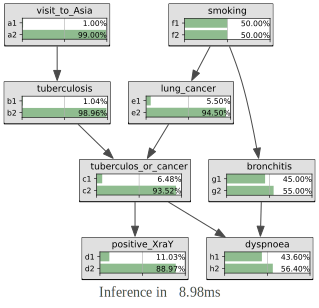

In [5]:
gnb.showInference(bn,evs={})

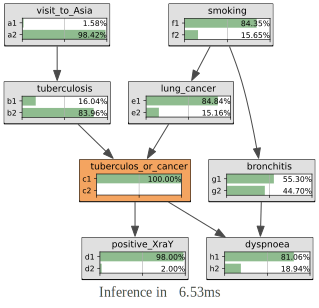

In [6]:
gnb.showInference(bn,evs={"tuberculos_or_cancer":"c1"})

## Generating Samples from Bayesian Net (no missing data)

In [7]:
NUM_SAMPLES = 1000

log_likelihood = gum.generateSample( bn, NUM_SAMPLES, "generated_bns/sample_asia_bn.csv", show_progress = True,  with_labels=True, random_order=True )


generated_bns/sample_asia_bn.csv: 100%|████████████████████|

Log2-Likelihood : -3268.8286510023745


In [8]:
# loading generated samples
samples = pd.read_csv( "generated_bns/sample_asia_bn.csv")
samples

n = 10
samples.iloc[0:n, :]

,tuberculosis,positive_XraY,tuberculos_or_cancer,smoking,visit_to_Asia,lung_cancer,bronchitis,dyspnoea
0,b2,d2,c2,f1,a2,e2,g2,h2
1,b2,d2,c2,f1,a2,e2,g1,h1
2,b2,d2,c2,f1,a2,e2,g2,h2
3,b2,d2,c2,f1,a2,e2,g1,h1
4,b2,d2,c2,f2,a2,e2,g1,h1
5,b2,d2,c2,f2,a2,e2,g2,h2
6,b2,d2,c2,f1,a2,e2,g1,h1
7,b2,d2,c2,f1,a2,e2,g1,h2
8,b2,d2,c2,f2,a2,e2,g2,h2
9,b2,d2,c2,f2,a2,e2,g2,h2


## Structure Learning - Multivariate Information based Inductive Causation - Constraint-Based

Paper: [Learning Causal Networks with Latent Variable from Multivariate Information in Genomic Data](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005662)

![](./imgs/miic.png)

**Summary:** Multivariate Information-based Inductive Causation (MIIC) is an algorithmic approach used to discover causal relationships within a given set of variables using statistical information. It is an extension of the Information-based Inductive Causation (IC) algorithm, which is a method to infer causal structures from observational data. MIIC is designed to handle multivariate (i.e., multiple variable) datasets, hence its name. The main goal of MIIC is to identify causal networks that can help us understand the underlying cause-and-effect relationships among variables.

**Algorithm:**

1. Start with a fully connected graph: MIIC begins with a complete graph (i.e., all nodes are connected) that represents all possible causal relationships between the variables in the dataset. Each edge in the graph represents a potential causal relationship.

2. Remove edges based on conditional mutual information: The algorithm then iteratively removes edges based on the statistical concept of conditional mutual information. The conditional mutual information between two variables X and Y, given a third variable Z, measures the amount of information that X and Y share, accounting for the influence of Z. If the conditional mutual information between two variables is low, given one or more conditioning variables, it suggests that the variables are conditionally independent, and the corresponding edge can be removed from the graph.


3. Orient the remaining edges: After removing the edges based on conditional mutual information, the algorithm works on orienting the remaining edges in the graph. MIIC uses the concept of "colliders" to achieve this. MIIC uses the concept of negative information to orient v-structures. Negative information is the signature of causality in observational data and is used to orient v-structures. Negative information is defined as I(X; Y; Z) < 0, where X, Y, and Z are three variables in the v-structure. If the negative information is present, then the edge between X and Y is oriented from the variable with the incoming edge to the variable with the outgoing edge.

4. Construct the final causal graph: Finally, MIIC combines the information from the previous steps to construct a causal graph representing the cause-and-effect relationships among the variables. This graph can be used to make inferences about the causal mechanisms driving the observed data.


In [9]:
ALGORITHM = "MIIC"
learner_miic = gum.BNLearner(samples)

# use prior
learner_miic.useSmoothingPrior()

# specify score function
learner_miic.useScoreLog2Likelihood() 

# specify learning algorithm
learner_miic.useMIIC()

# learn network
bn_miic = learner_miic.learnBN()

print(learner_miic)

gnb.sideBySide(bn,bn_miic,gnb.getBNDiff(bn,bn_miic),explain.getInformation(bn_miic),captions=["Original BN","Learned BN using " + ALGORITHM,"Graphical diff","information"])


Filename       : /var/folders/0y/t87_51k91_gb6dw_gks_hvq40000gn/T/tmph0k8pxy0.csv
Size           : (1000,8)
Variables      : tuberculosis[2], positive_XraY[2], tuberculos_or_cancer[2], smoking[2], visit_to_Asia[2], lung_cancer[2], bronchitis[2], dyspnoea[2]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : Log2Likelihood
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000



### Check Conditional Probability Tables

In [10]:
gnb.sideBySide( bn.cpt( "smoking" ), bn_miic.cpt( "visit_to_Asia" ), bn_miic.cpt( "lung_cancer" ), bn_miic.cpt( "tuberculosis" ), bn_miic.cpt( "bronchitis" ), bn_miic.cpt( "tuberculos_or_cancer" ), bn_miic.cpt( "dyspnoea" ), bn_miic.cpt( "positive_XraY" ) )

In [11]:
gnb.sideBySide("<H3>Original BN</H3>","<H3>Learned NB</H3>",\
    bn.cpt ('visit_to_Asia'),bn_miic.cpt ('visit_to_Asia'),\
        bn.cpt ('smoking'),bn_miic.cpt ('smoking'),\
        bn.cpt ('tuberculosis'),bn_miic.cpt ('tuberculosis'),\
        bn.cpt ('tuberculos_or_cancer'),bn_miic.cpt ('tuberculos_or_cancer'),\
        bn.cpt ('positive_XraY'),bn_miic.cpt ('positive_XraY'),\
        bn.cpt ('dyspnoea'),bn_miic.cpt ('dyspnoea'),\
        bn.cpt ('lung_cancer'),bn_miic.cpt ('lung_cancer'),\
        bn.cpt ('bronchitis'),bn_miic.cpt ('bronchitis'),\
        ncols=2)

### Measuring the Quality of the Learnt Structure



In [12]:
# using Jensen-Shannon divergence
kl_miic=gum.ExactBNdistance(bn,bn_miic)
kl_miic.compute()['jensen-shannon']

0.004030164513170161

## Structure Learning - Greedy Hill Climbing - Score-Based

In [96]:
ALGORITHM = "Greedy Hill Climbing"
learner_ghc = gum.BNLearner(samples)

# use prior
learner_ghc.useSmoothingPrior()

# specify score function
learner_ghc.useScoreLog2Likelihood() 

# specify learning algorithm
learner_ghc.useGreedyHillClimbing()

# add contextual knowledge
# learner_ghc.addMandatoryArc("visit_to_Asia","tuberculosis")

#learner_ghc.setMaxTime(10)
#learner_ghc.setEpsilon(1e-10)
#gnb.animApproximationScheme(learner_ghc, scale=pseudolog) 

# learn network
bn_ghc = learner_ghc.learnBN()

print(learner_ghc)

gnb.sideBySide(bn,bn_ghc,gnb.getBNDiff(bn,bn_ghc),explain.getInformation(bn_ghc),captions=["Original BN","Learned BN using " + ALGORITHM,"Graphical diff","information"])


Filename       : /var/folders/sh/yfwy9_gn2gjcw7xcsnv37y_w0000gp/T/tmpv3vzyach.csv
Size           : (1000,8)
Variables      : tuberculos_or_cancer[2], positive_XraY[2], tuberculosis[2], bronchitis[2], visit_to_Asia[2], lung_cancer[2], dyspnoea[2], smoking[2]
Induced types  : True
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : Log2Likelihood
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000



### Check Conditional Probability Tables

In [128]:
gnb.sideBySide( bn_ghc.cpt( "smoking" ), bn_ghc.cpt( "visit_to_Asia" ), bn_ghc.cpt( "lung_cancer" ), bn_ghc.cpt( "tuberculosis" ), bn_ghc.cpt( "bronchitis" ), bn_ghc.cpt( "tuberculos_or_cancer" ), bn_ghc.cpt( "dyspnoea" ), bn_ghc.cpt( "positive_XraY" ) )

In [46]:
gnb.sideBySide("<H3>Original BN</H3>","<H3>Learned NB</H3>",\
    bn.cpt ('visit_to_Asia'),bn_ghc.cpt ('visit_to_Asia'),\
        bn.cpt ('smoking'),bn_ghc.cpt ('smoking'),\
        bn.cpt ('tuberculosis'),bn_ghc.cpt ('tuberculosis'),\
        bn.cpt ('tuberculos_or_cancer'),bn_ghc.cpt ('tuberculos_or_cancer'),\
        bn.cpt ('positive_XraY'),bn_ghc.cpt ('positive_XraY'),\
        bn.cpt ('dyspnoea'),bn_ghc.cpt ('dyspnoea'),\
        bn.cpt ('lung_cancer'),bn_ghc.cpt ('lung_cancer'),\
        bn.cpt ('bronchitis'),bn_ghc.cpt ('bronchitis'),\
        ncols=2)

### Measuring the Quality of the Learnt Structure


In [85]:
# using Jensen-Shannon divergence
kl_ghc=gum.ExactBNdistance(bn,bn_ghc)
kl_ghc.compute()['jensen-shannon']

0.0067892206012089085

## Hybrid Approaches (GHC + MIIC)

In [100]:
ALGORITHM = "GHC + MIIC"
learner_hybrid = gum.BNLearner(samples)
learner_hybrid.useSmoothingPrior()

# specify score function
learner_hybrid.useScoreLog2Likelihood() 

# specify learning algorithm
learner_hybrid.useMIIC()

# learn network
bn_hybrid = learner_hybrid.learnBN()

print(learner_hybrid)

gnb.sideBySide(bn,bn_hybrid,gnb.getBNDiff(bn,bn_hybrid),explain.getInformation(bn_hybrid),captions=["Original BN","Learned BN using " + ALGORITHM,"Graphical diff","information"])



Filename       : /var/folders/sh/yfwy9_gn2gjcw7xcsnv37y_w0000gp/T/tmpyak4vn07.csv
Size           : (1000,8)
Variables      : tuberculos_or_cancer[2], positive_XraY[2], tuberculosis[2], bronchitis[2], visit_to_Asia[2], lung_cancer[2], dyspnoea[2], smoking[2]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : Log2Likelihood
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000



In [101]:
ALGORITHM = "GHC + MIIC"
learner_hybrid = gum.BNLearner(samples)
learner_hybrid.useSmoothingPrior()

# specify score function
learner_hybrid.useScoreLog2Likelihood() 

# specify learning algorithm
learner_hybrid.useEM(epsilon=0.0001)
#learner_hybrid.useMIIC()
learner_hybrid.setInitialDAG(bn_hybrid.dag())

# learn network
bn_hybrid = learner_hybrid.learnBN()

print(learner_hybrid)

gnb.sideBySide(bn,bn_hybrid,gnb.getBNDiff(bn,bn_hybrid),explain.getInformation(bn_hybrid),captions=["Original BN","Learned BN using " + ALGORITHM,"Graphical diff","information"])

Filename       : /var/folders/sh/yfwy9_gn2gjcw7xcsnv37y_w0000gp/T/tmprkj07is1.csv
Size           : (1000,8)
Variables      : tuberculos_or_cancer[2], positive_XraY[2], tuberculosis[2], bronchitis[2], visit_to_Asia[2], lung_cancer[2], dyspnoea[2], smoking[2]
Induced types  : True
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : Log2Likelihood
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000
EM             : True
EM epsilon     : 0.000100  (But no missing values in this database)
Initial DAG    : True  (digraph {
     0;
     1;
     2;
     3;
     4;
     5;
     6;
     7;

     0 -> 1;
     7 -> 5;
     3 -> 7;
     5 -> 0;
     2 -> 0;
     5 -> 6;
     3 -> 6;
}

)



## Impact of the size of the database for the learning


In [134]:
log_likelihood = gum.generateSample( bn, 500000, "generated_bns/sample_asia_bn_50000.csv", show_progress = True,  with_labels=True, random_order=True )

rows=3
sizes=[400,500,700,1000,2000,5000,
       10000,50000,75000,
       100000,150000,175000,
       200000,300000,500000]

def extract_asia(n):
    """
    extract n line from asia.csv to extract.csv
    """
    samples = pd.read_csv( "generated_bns/sample_asia_bn_50000.csv")
    return samples.iloc[0:n, :]

generated_bns/sample_asia_bn_50000.csv: 100%|██████████████|


Log2-Likelihood : -1616943.7028889107


(400,8)
(500,8)
(700,8)
(1000,8)
(2000,8)
(5000,8)
(10000,8)
(50000,8)
(75000,8)
(100000,8)
(150000,8)
(175000,8)
(200000,8)
(300000,8)
(500000,8)


3.348546147608129e-05


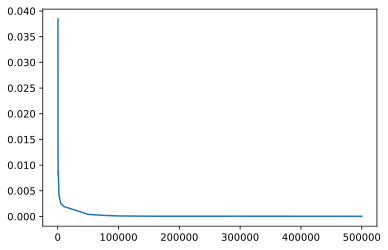

In [135]:
gnb.flow.clear()
nbr=0
l=[]
for i in sizes:
    samples_i = extract_asia(i)
    learner=gum.BNLearner(samples_i, bn) # using bn as template for variables
    learner.useGreedyHillClimbing()
    print(learner.state()["Size"][0])
    bn2=learner.learnBN()

    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])

    gnb.flow.add(gnb.getBNDiff(bn,bn2,size='3!'),f"size={i}")

gnb.flow.display()
plot(sizes,l)
print(l[-1])

- Explore more structure learning algorithms based on Bayesian approaches
- quantify the uncertainty -> decision-making -> help make decision to narrow down what the true graph is
- PC-algo 
- ordreing, partition, layer MCMC are based on the PC-ago as a starting point

** -> GaussianBNs ** 



(400,8)
(500,8)
(700,8)
(1000,8)
(2000,8)
(5000,8)
(10000,8)
(50000,8)
(75000,8)
(100000,8)
(150000,8)
(175000,8)
(200000,8)
(300000,8)
(500000,8)


2.919904314912635e-05


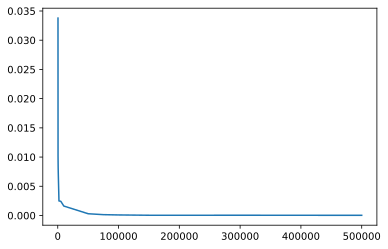

In [138]:
gnb.flow.clear()
nbr=0
l=[]
for i in sizes:
    samples_i = extract_asia(i)
    learner=gum.BNLearner(samples_i, bn) # using bn as template for variables
    learner.useMIIC()
    learner.addMandatoryArc("smoking","bronchitis")
    print(learner.state()["Size"][0])
    bn2=learner.learnBN()

    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])

    gnb.flow.add(gnb.getBNDiff(bn,bn2,size='3!'),f"size={i}")

gnb.flow.display()
plot(sizes,l)
print(l[-1])

## Causal Graphs

In [102]:
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

Let's consider the MIIC Bayesian Network as a Causal BN

In [109]:
model = csl.CausalModel(bn_miic)
model

In [110]:
cslnb.showCausalImpact(model,"lung_cancer", "smoking", values={"smoking":"f2"})


$$\begin{equation*}P( lung\_cancer \mid \hookrightarrow\mkern-6.5musmoking) = P\left(lung\_cancer\mid smoking\right)\end{equation*}$$
